In [4]:
%load_ext Cython

Iso contour implementation using Cython with a 2d-array for the indexes.

In [20]:
%%cython --cplus -a

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]


cdef struct next_segment_t:
    int yx
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonArrayOpt(object):
    """Iso contour implementation using Cython with a 2d-array for the indexes.

    TODO: remove _backward_points
    TODO: use C array for _indexes
    TODO: concept of x,y could be removed for a single yx-index
    """
    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef cnumpy.uint8_t *_index_ptr
    cdef int _dim_x
    cdef int _dim_y

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef vector[cnumpy.float32_t] _forward_points
    cdef vector[cnumpy.float32_t] _backward_points
    cdef cnumpy.uint8_t[:, :] _indexes

    def __init__(self, image, mask=None):
        cdef:
            int wh
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]
            wh = self._dim_y + self._dim_x
            self._forward_points.reserve(wh)
            self._backward_points.reserve(wh)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _create_marching_squares(self, double isovalue):
        cdef:
            int i
            int x, y, i_segment, i_side, i_edge, indexes_count = 0
            cnumpy.uint8_t index
            cnumpy.uint8_t *_index_ptr
            double tmpf
            cnumpy.float32_t *_image_ptr
            cnumpy.int8_t *_mask_ptr

        # allow dim_y/_x instead of dim_y-1/_x-1 to have everything aligned in memory
        self._indexes = numpy.zeros((self._dim_y, self._dim_x), dtype=numpy.uint8)
        with nogil:
            self._index_ptr = &self._indexes[0][0]
            _index_ptr = self._index_ptr
            _image_ptr = self._image_ptr
            _mask_ptr = self._mask_ptr
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    # Calculate index.
                    index = 0
                    if _image_ptr[0] > isovalue:
                        index += 1
                    if _image_ptr[1] > isovalue:
                        index += 2
                    if _image_ptr[self._dim_x] > isovalue:
                        index += 8
                    if _image_ptr[self._dim_x + 1] > isovalue:
                        index += 4

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (_image_ptr[0] +
                                       _image_ptr[1] +
                                       _image_ptr[self._dim_x] +
                                       _image_ptr[self._dim_x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if _mask_ptr != NULL:
                        _mask_ptr += 1
                        if _mask_ptr[0] > 0:
                            index += 16
                        if _mask_ptr[1] > 0:
                            index += 32
                        if _mask_ptr[self._dim_x] > 0:
                            index += 128
                        if _mask_ptr[self._dim_x + 1] > 0:
                            index += 64

                    if index < 16 and index != 0 and index != 15:
                        _index_ptr[0] = index

                    _index_ptr += 1
                    _image_ptr += 1

                # There is a missing pixel at the end of each rows
                _index_ptr += 1
                _image_ptr += 1
                if _mask_ptr != NULL:
                    _mask_ptr += 1

        return self._indexes

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
            cnumpy.uint_t x,
            cnumpy.uint_t y,
            cnumpy.uint8_t edge,
            double isovalue,
            cnumpy.float32_t *result) nogil:
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy1) * self._dim_x + x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy2) * self._dim_x + x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = x + fx
        result[1] = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_next_segment(self,
                       cnumpy.int_t yx,
                       cnumpy.int_t x, cnumpy.int_t y,
                       cnumpy.uint8_t index,
                       cnumpy.uint8_t edge,
                       next_segment_t *result) nogil:
        cdef:
            int next_x, next_y, next_edge, next_index
            cnumpy.int8_t *edges

        index = index & 0x0F
        if  index == 0 or index == 15:
            result.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                self._index_ptr[yx] = 7
            else:
                # it's the second segment
                index = 8
                self._index_ptr[yx] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                self._index_ptr[yx] = 4
            else:
                # it's the second segment
                index = 4
                self._index_ptr[yx] = 1
        else:
            self._index_ptr[yx] = 0

        # next
        if edge == 0:
            next_x = x
            next_y = y - 1
        elif edge == 1:
            next_x = x + 1
            next_y = y
        elif edge == 2:
            next_x = x
            next_y = y + 1
        elif edge == 3:
            next_x = x - 1
            next_y = y
        else:
            with gil:
                assert False, "Unexpected behaviour"
        if next_x >= self._dim_x - 1 or next_y >= self._dim_y - 1 or next_x < 0 or next_y < 0:
            # out of the indexes
            result.x = -1
            return

        next_yx = next_y * self._dim_x + next_x
        next_index = self._index_ptr[next_yx]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            result.x = -1
            return

        # top became down, up be came down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        result.x = next_x
        result.y = next_y
        result.yx = next_yx
        result.index = next_index
        result.edge = next_edge

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygon(self, double isovalue, int yx, int x, int y):
        cdef:
            int i
            cnumpy.uint8_t index, edge
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t next_segment

        with nogil:
            index = self._index_ptr[yx]
            index = index & 0x0F

            self._forward_points.clear()
            self._backward_points.clear()

            edge = CELL_TO_EDGE[index][1 + 0]
            first_pos.yx = yx
            first_pos.x = x
            first_pos.y = y
            first_pos.index = index
            first_pos.edge = edge
            self._compute_point(x, y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

            edge = CELL_TO_EDGE[index][1 + 1]
            self._compute_point(x, y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

            while True:
                self._compute_next_segment(yx, x, y, index, edge, &next_segment)
                if next_segment.x < 0:
                    break
                yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
                self._compute_point(x, y, edge, isovalue, point)
                self._forward_points.push_back(point[0])
                self._forward_points.push_back(point[1])

            yx, x, y, index, edge = first_pos.yx, first_pos.x, first_pos.y, first_pos.index, first_pos.edge
            while True:
                self._compute_next_segment(yx, x, y, index, edge, &next_segment)
                if next_segment.x < 0:
                    break
                yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
                self._compute_point(x, y, edge, isovalue, point)
                self._backward_points.push_back(point[1])
                self._backward_points.push_back(point[0])

        result = numpy.empty(self._forward_points.size() + self._backward_points.size(), dtype=numpy.float32)
        if self._backward_points.size() > 0:
            result[self._backward_points.size() - 1::-1] = self._backward_points
        result[self._backward_points.size():] = self._forward_points
        result = result.reshape(-1, 2)
        return result

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self, double isovalue):
        cdef:
            int x, y, yx
            cnumpy.uint8_t index
        polygons = []
        with nogil:
            yx = 0
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    index = self._index_ptr[yx]
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        yx += 1
                        continue
                    with gil:
                        polygon = self._extract_polygon(isovalue, yx, x, y)
                        polygons.append(polygon)

                    if index == 5 or index == 10:
                        index = self._index_ptr[yx]
                        index = index & 0x0F
                        if index == 0 or index == 15:
                            yx += 1
                            continue
                        # There is maybe a second polygon to extract
                        with gil:
                            polygon = self._extract_polygon(isovalue, yx, x, y)
                            polygons.append(polygon)
                    yx += 1
                yx += 1

        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._create_marching_squares(value)
        polygons = self._extract_polygons(value)
        return polygons


ThisMarchingSquare = MarchingSquareCythonArrayOpt

Test
====

In [21]:
image = numpy.array([[0, 0, 1],
                     [0, 1, 1],
                     [0, 1, 1],
                     [0, 0, 1]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[1.5, 0. ],
       [1. , 0.5],
       [0.5, 1. ],
       [0.5, 2. ],
       [1. , 2.5],
       [1.5, 3. ]], dtype=float32)]


In [22]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2. , 0.5],
       [1.5, 1. ],
       [1. , 1.5],
       [0.5, 2. ],
       [1. , 2.5],
       [1.5, 3. ],
       [2. , 3.5],
       [2.5, 3. ],
       [3. , 2.5],
       [4. , 2.5],
       [4.5, 2. ],
       [4. , 1.5],
       [3.5, 1. ],
       [3. , 0.5],
       [2. , 0.5]], dtype=float32)]


Utils
=====

In [23]:
%matplotlib nbagg

In [24]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result

In [25]:
def plot_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    import matplotlib.pyplot as plt
    matplotlib.interactive(True)

    fig, ax = plt.subplots()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, problem.image.shape[0]])
    ax.set_xlim([0, problem.image.shape[1]])
    ax.invert_yaxis()

    # image
    plt.imshow(problem.image, cmap="Greys", alpha=.5)
    
    # mask
    mask = numpy.ma.masked_where(problem.mask == 0, problem.mask)
    plt.imshow(mask, cmap="cool", alpha=.5)

    # iso contours
    colors = ["#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"]
    for ivalue, value in enumerate(problem.values):
        color = colors[ivalue % len(colors)]
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            p = Polygon(p, fill=False, edgecolor=color, closed=False)
            ax.add_patch(p)

    plt.show()

In [26]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values"])

ROOT = os.getcwd()

def create_test_problem():
    import fabio
    data = fabio.open(ROOT + "/data/data.tif").data
    mask = fabio.open(ROOT + "/data/mask.tif").data
    mask = mask == 0
    values = range(10, 1000, int(240/6))[0:7]
    return Problem(data, mask, values)

def create_wos_problem():
    # Problem containing a WOS XPad with pixel displacment and mask
    import fabio
    data = numpy.load(ROOT + "/data/wos_tth.npz")
    image = data["tth"]
    mask = fabio.open(ROOT + "/data/wos_mask.edf").data
    mask = (mask != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_1441_problem():
    # Problem containing an image of 4096x4096 with 1441 rings
    data = numpy.load(ROOT + "/data/id22_1441.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

Test without mask
=================

In [27]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

115 ms ± 731 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test with mask
==============

In [28]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]

378 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.8 ms ± 91.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


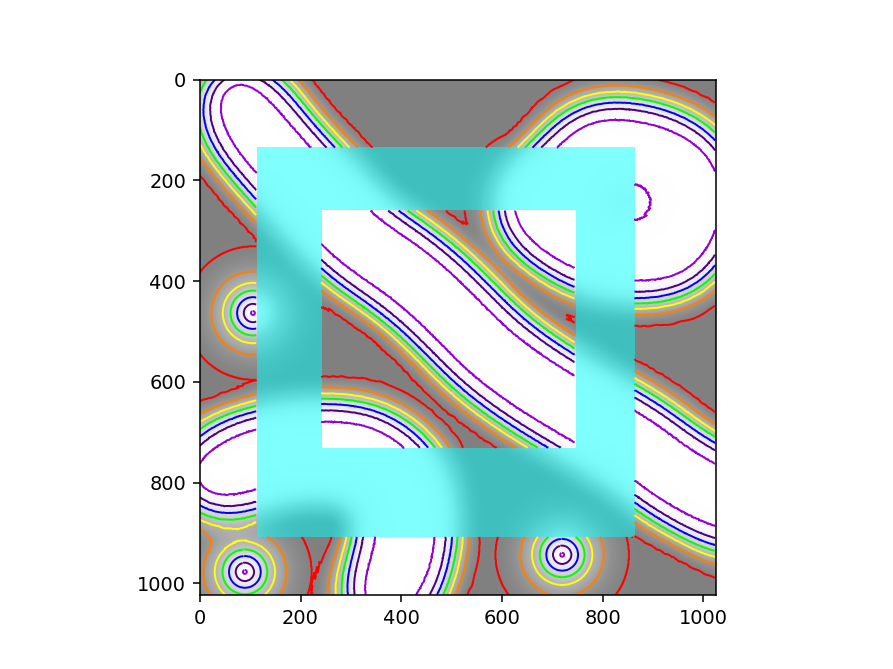

In [11]:
problem = create_test_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

WOS detector (700K pixels)
==========================

In [12]:
problem = create_wos_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
473 ms ± 7.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.1 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Without mask
131 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.3 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


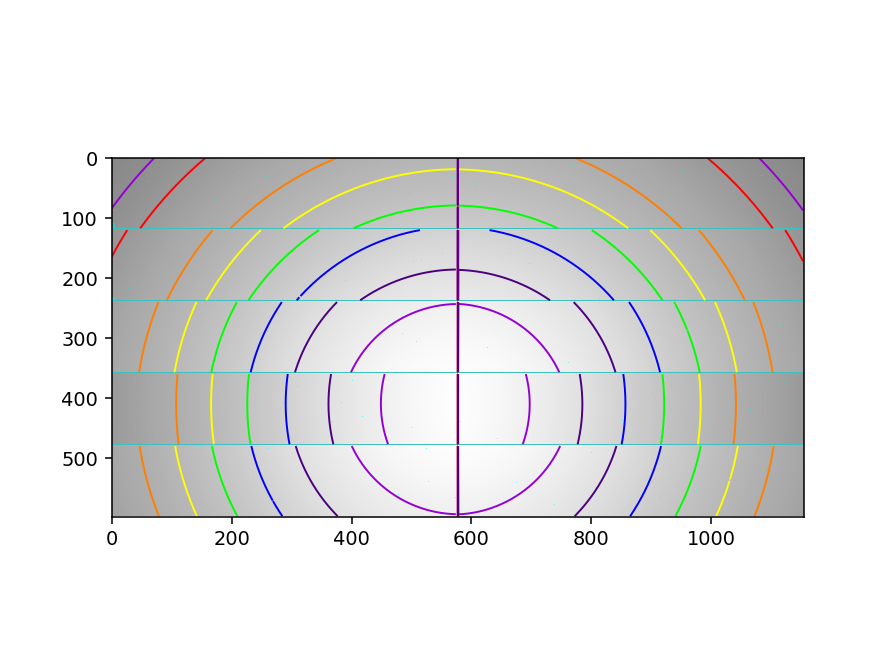

In [13]:
problem = create_wos_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

Perkin Elmer (16M pixels)
===================

In [14]:
problem = create_id22_17_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
1.89 s ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.66 s ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without mask
1.59 s ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 s ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


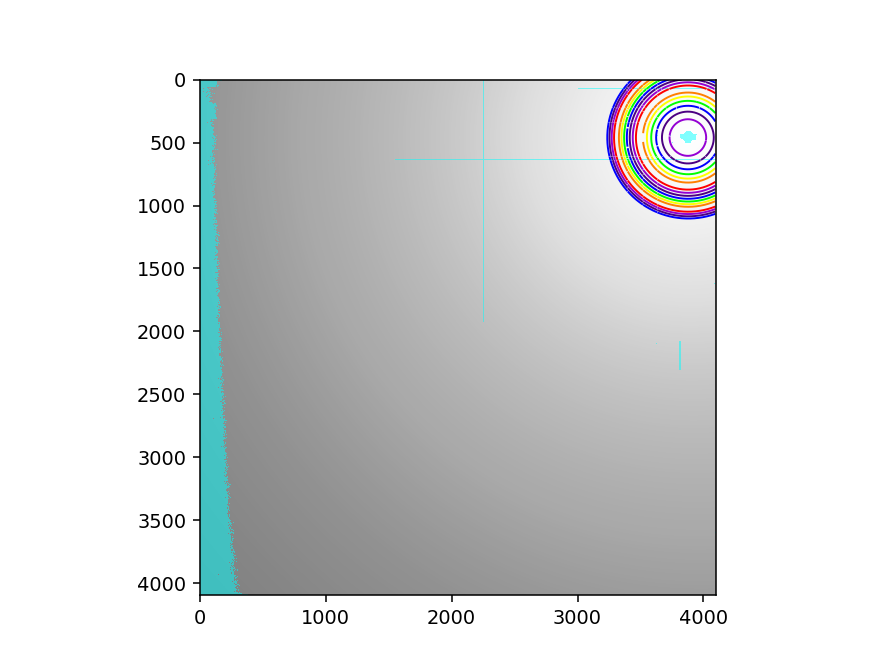

In [15]:
problem = create_id22_17_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)